# Multiple ROI Analysis using DeepLabCut CSV files

## Import Libraries 

In [14]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import matplotlib.patches as patches
from collections import Counter

## Import Data

In [15]:

# Load CSV data, using the second and third rows as the header
df = pd.read_csv(r"C:\Users\Farha\Downloads\Mouse 1 W_W 12_2_23DLC_resnet101_TMZ_Model_V2Dec16shuffle1_157000_filtered.csv", header=[1, 2])
print(df.columns)

MultiIndex([('bodyparts',     'coords'),
            (     'Head',          'x'),
            (     'Head',          'y'),
            (     'Head', 'likelihood'),
            (     'Nose',          'x'),
            (     'Nose',          'y'),
            (     'Nose', 'likelihood'),
            (  'LeftEar',          'x'),
            (  'LeftEar',          'y'),
            (  'LeftEar', 'likelihood'),
            ( 'RightEar',          'x'),
            ( 'RightEar',          'y'),
            ( 'RightEar', 'likelihood'),
            (   'Thorax',          'x'),
            (   'Thorax',          'y'),
            (   'Thorax', 'likelihood'),
            ( 'TailBase',          'x'),
            ( 'TailBase',          'y'),
            ( 'TailBase', 'likelihood')],
           )


## Create List of Body Part From CSV Headers

In [16]:
# Create a dictionary to map body part names to coordinate columns
body_part_data = {}
unique_body_parts = df.columns.get_level_values(0).unique().tolist()
unique_body_parts.remove('bodyparts')

for part in unique_body_parts:
    body_part_data[part] = {
        "x": df.loc[:, (part, 'x')].to_numpy(),
        "y": df.loc[:, (part, 'y')].to_numpy(),
        "likelihood": df.loc[:, (part, 'likelihood')].to_numpy()
    }

for part in body_part_data.keys():
    print(f"body parts: {part}")

body parts: Head
body parts: Nose
body parts: LeftEar
body parts: RightEar
body parts: Thorax
body parts: TailBase


## Draw Necessary ROIs

<IPython.core.display.Javascript object>


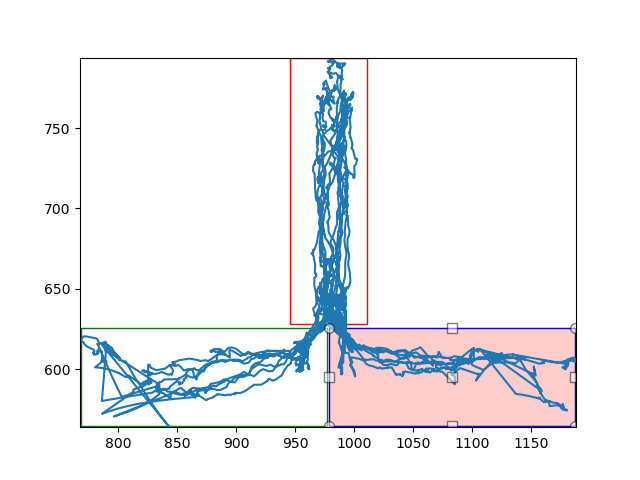

In [5]:
# Change the name of 'roi_names' and colors variable to match the ROIs you want to use.
# Initialize variables for ROIs
roi_coords = []
roi_names = ["Middle Arm", "Right Arm", "Left Arm"]  # Predefine the names of your ROIs
colors = ['r', 'g', 'b']  # Colors for each ROI

# Function to be called when the rectangle is drawn
def onselect(eclick, erelease):
    if len(roi_names) <= len(roi_coords):
        print("You've drawn all the ROIs. Please restart the process if you want to draw more ROIs.")
        return
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    roi_coords.append((x1, y1, x2, y2))
    name = roi_names[len(roi_coords) - 1]  # Get the name of the current ROI
    color = colors[len(roi_coords) - 1]  # Get the color for the current ROI
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    print(f"ROI '{name}': ({x1}, {y1}), ({x2}, {y2})")

# Function to add a name for each ROI
def add_roi_name(name):
    roi_names.append(name)

# Plot the data for the 'Nose' body part
fig, ax = plt.subplots()
Head_x = body_part_data['Thorax']['x']
Head_y = body_part_data['Thorax']['y']
ax.plot(Head_x, Head_y, label='Thorax')

# Set the limits of the axes to fit the data
ax.set_xlim([min(Head_x), max(Head_x)])
ax.set_ylim([min(Head_y), max(Head_y)])

# Invert the y-axis
ax.invert_yaxis()

# Set useblit=True on most backends for enhanced performance
toggle_selector = RectangleSelector(ax, onselect, useblit=True,
                                    button=[1],  # Left mouse button
                                    minspanx=5, minspany=5,
                                    spancoords='pixels',
                                    interactive=True)

plt.show()


## Calculate Time Spent in Each ROI

In [17]:
# User-configurable list of body part pairs to track
body_part_pairs = [("Thorax", "Head")]  # Example pair; user can change body parts to match their own experiments

# Initialize the dictionaries
distances = {}
roi_time_spent = {name: {f"{part1}-{part2}": 0 for part1, part2 in body_part_pairs} for name in roi_names}

# Define function to check if points are in the ROI
def is_in_roi(x, y, roi):
    x1, y1, x2, y2 = roi
    return (x1 < x < x2) and (y1 < y < y2)

# Function to calculate distance between two points
def calculate_distance(part_data_1, part_data_2, index):
    return np.sqrt((part_data_1["x"][index] - part_data_2["x"][index])**2 +
                   (part_data_1["y"][index] - part_data_2["y"][index])**2)

# Function to update time spent in ROI
def update_time_spent(roi_time_spent, part_pair, condition, roi_name):
    if condition:
        roi_time_spent[roi_name][part_pair] += 1

# Function to calculate total time spent in ROI
def calculate_total_time_in_roi(roi_time_spent):
    return sum(roi_time_spent.values())

# Calculate distances and time spent in ROI for each body part pair
for part1, part2 in body_part_pairs:
    distances[f"{part1}-{part2}"] = [calculate_distance(body_part_data[part1], body_part_data[part2], index)
                                      for index in range(len(df))]

    # Update time spent in ROI for each frame
    for index in range(len(df)):
        for roi, name in zip(roi_coords, roi_names):
            update_time_spent(roi_time_spent, f"{part1}-{part2}",
                              is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi), name)

# Calculate and print the total time spent in each ROI
for name in roi_names:
    total_time_in_roi = calculate_total_time_in_roi(roi_time_spent[name])
    print(f"Total time spent in {name} ROI: {total_time_in_roi} frames")


Total time spent in Middle Arm ROI: 5586 frames
Total time spent in Right Arm ROI: 1967 frames
Total time spent in Left Arm ROI: 1335 frames


## Analyze the Number of Entries and Exits, inculding the First Entry ROI

In [18]:
# Initialize the dictionaries
debounce_frames= 15
roi_entries_exits = {name: {f"{part1}-{part2}": {"entries": 0, "exits": 0, "in_roi": False, "debounce_counter": 0} for part1, part2 in body_part_pairs} for name in roi_names}
first_entry_roi = None
starting_roi = None

# Update entries and exits for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            in_roi = is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi)
            if index == 0 and in_roi:
                starting_roi = name
            if in_roi and not roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["entries"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = True
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                    if first_entry_roi is None and name != starting_roi:
                        first_entry_roi = name
            elif not in_roi and roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["exits"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = False
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
            else:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0

# Print the number of entries and exits for each ROI
for name in roi_names:
    for part1, part2 in body_part_pairs:
        print(f"ROI '{name}', Body Part Pair '{part1}-{part2}': {roi_entries_exits[name][f'{part1}-{part2}']['entries']} entries, {roi_entries_exits[name][f'{part1}-{part2}']['exits']} exits")

# Print the first entry ROI
print(f"The first entry was in the ROI: {first_entry_roi}")


ROI 'Middle Arm', Body Part Pair 'Thorax-Head': 16 entries, 15 exits
ROI 'Right Arm', Body Part Pair 'Thorax-Head': 7 entries, 7 exits
ROI 'Left Arm', Body Part Pair 'Thorax-Head': 7 entries, 7 exits
The first entry was in the ROI: Right Arm


## Graph the Number of Entries and Exits Per ROI

<IPython.core.display.Javascript object>


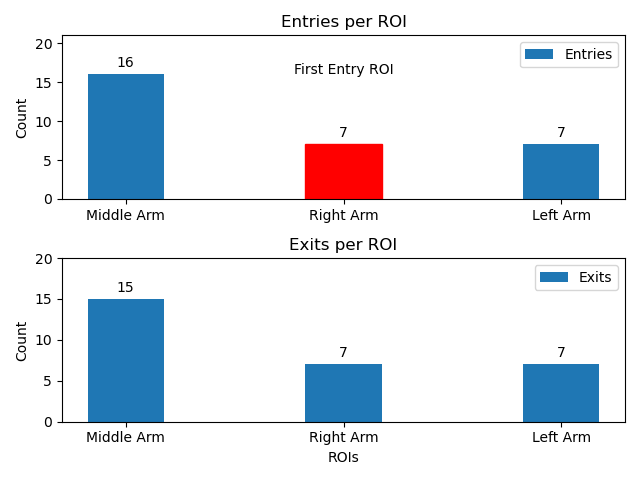

In [19]:
# Prepare data for the bar graph
roi_names = list(roi_entries_exits.keys())
entries = [roi_entries_exits[name][f"{part1}-{part2}"]['entries'] for name in roi_names for part1, part2 in body_part_pairs]
exits = [roi_entries_exits[name][f"{part1}-{part2}"]['exits'] for name in roi_names for part1, part2 in body_part_pairs]

# Create a figure and a set of subplots
fig, axs = plt.subplots(2)

# Set the bar width
bar_width = 0.35

# Get the x locations for the groups
x = np.arange(len(roi_names))

# Plot the bars for entries
rects1 = axs[0].bar(x, entries, bar_width, label='Entries')
axs[0].set_ylabel('Count')
axs[0].set_title('Entries per ROI')
axs[0].set_xticks(x)
axs[0].set_xticklabels(roi_names)
axs[0].legend()
axs[0].set_ylim([0, max(entries) + 5])  # Set y-axis limits

# Plot the bars for exits
rects2 = axs[1].bar(x, exits, bar_width, label='Exits')
axs[1].set_xlabel('ROIs')
axs[1].set_ylabel('Count')
axs[1].set_title('Exits per ROI')
axs[1].set_xticks(x)
axs[1].set_xticklabels(roi_names)
axs[1].legend()
axs[1].set_ylim([0, max(exits) + 5])  # Set y-axis limits

# Function to add labels on the bars
def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(axs[0], rects1)
autolabel(axs[1], rects2)

# Color code the first entry ROI
if first_entry_roi is not None:
    rects1[roi_names.index(first_entry_roi)].set_color('r')
    axs[0].text(roi_names.index(first_entry_roi), max(entries), 'First Entry ROI', ha='center')

# Show the plot
plt.tight_layout()
plt.show()


## Calculate Velocities and Graph Velocities Per ROI

In [20]:
# Assuming body_part_data is a dictionary with keys as body parts
body_parts = list(body_part_data.keys())

# Parameter for frame rate
frame_rate = 30  # Replace with your actual frame rate

# Initialize the dictionary for velocities
velocities = {}

# Calculate velocities and apply Savitzky-Golay filter for smoothing
for part in body_parts:
    # Ensure there are enough data points for velocity calculation
    if len(body_part_data[part]["x"]) > 1:
        # Calculate velocity as the difference in position over time
        velocities[part] = np.diff(body_part_data[part]["x"]) / frame_rate
        
        # Determine the window length for the Savitzky-Golay filter
        # It must be odd and less than the size of the data
        window_length = min(15, len(velocities[part]) // 2 * 2 + 1)
        
        # Apply the Savitzky-Golay filter if the window length is valid
        if window_length > 2:  # At least 3 points are needed to apply the filter
            velocities[part] = savgol_filter(velocities[part], window_length=window_length, polyorder=3)
        else:
            print(f"Not enough data points to apply Savitzky-Golay filter for {part}.")
    else:
        print(f"Not enough data points to calculate velocity for {part}.")

average_velocities = {}

# Iterate over each body part to calculate and print the average velocity
for part in body_parts:
    # Calculate the average velocity for each body part
    average_velocity = np.mean(np.abs(velocities[part]))
    # Store the average velocity in the dictionary
    average_velocities[part] = average_velocity
    # Print the average velocity for each body part
    print(f"Average velocity for {part}: {average_velocity:.2f} pixels/seconds")

    # Initialize the dictionary for average velocities of paired body parts
average_velocities_pairs = {}

# Iterate over each pair of body parts to calculate and print the average velocity
for part1, part2 in body_part_pairs:
    # Calculate the average velocity for each pair of body parts
    average_velocity_pair = np.mean(np.abs(velocities[part1]) + np.abs(velocities[part2])) / 2
    # Store the average velocity in the dictionary
    average_velocities_pairs[f"{part1}-{part2}"] = average_velocity_pair
    # Print the average velocity for each pair of body parts
    print(f"Average velocity for {part1}-{part2}: {average_velocity_pair:.2f} pixels/seconds")


Average velocity for Head: 0.03 pixels/seconds
Average velocity for Nose: 0.03 pixels/seconds
Average velocity for LeftEar: 0.03 pixels/seconds
Average velocity for RightEar: 0.03 pixels/seconds
Average velocity for Thorax: 0.02 pixels/seconds
Average velocity for TailBase: 0.03 pixels/seconds
Average velocity for Thorax-Head: 0.02 pixels/seconds


#### Graph Average Velocities of Paired-Body Parts for Each ROI

Average velocity in ROI 'Middle Arm' for Thorax-Head: -0.00 pixels/seconds
Average velocity in ROI 'Right Arm' for Thorax-Head: 0.00 pixels/seconds
Average velocity in ROI 'Left Arm' for Thorax-Head: 0.00 pixels/seconds


<IPython.core.display.Javascript object>


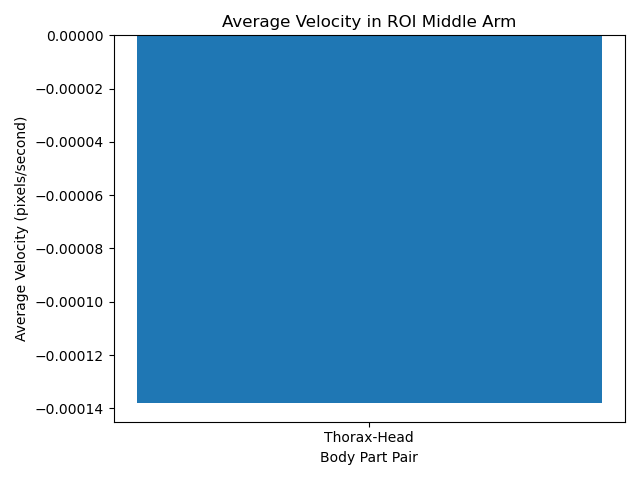

<IPython.core.display.Javascript object>


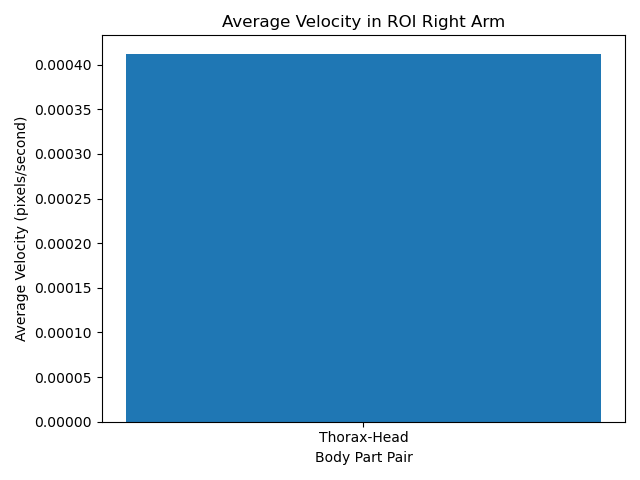

<IPython.core.display.Javascript object>


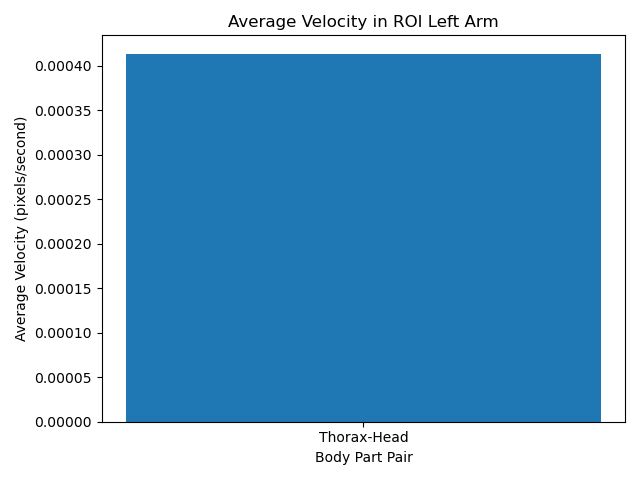

In [21]:
# Initialize a dictionary to store the velocities in each ROI
velocities_in_rois = {name: {f"{part1}-{part2}": [] for part1, part2 in body_part_pairs} for name in roi_names}

# Assign velocities to ROIs for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            if is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi) and is_in_roi(body_part_data[part2]["x"][index], body_part_data[part2]["y"][index], roi):
                velocities_in_rois[name][f"{part1}-{part2}"].append((velocities[part1][index] + velocities[part2][index]) / 2 if index < len(velocities[part1]) and index < len(velocities[part2]) else np.nan)

# Calculate the average velocity for each ROI
average_velocities_in_rois = {name: {pair: np.nanmean(velocities) for pair, velocities in pairs.items()} for name, pairs in velocities_in_rois.items()}

# Print the average velocity for each ROI
for name in roi_names:
    for pair in body_part_pairs:
        pair_name = f"{pair[0]}-{pair[1]}"
        print(f"Average velocity in ROI '{name}' for {pair_name}: {average_velocities_in_rois[name][pair_name]:.2f} pixels/seconds")

# Plot the average velocity for each ROI
for name in roi_names:
    plt.figure()  # Create a new figure
    plt.bar(average_velocities_in_rois[name].keys(), average_velocities_in_rois[name].values())
    plt.xlabel('Body Part Pair')
    plt.ylabel('Average Velocity (pixels/second)')
    plt.title(f'Average Velocity in ROI {name}')
    plt.tight_layout()  # Adjust the layout
    plt.show()

## Track the Sequence of ROI visits

In [22]:
# Initialize the list to store the sequence of ROIs
roi_sequence = []

# Update entries for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            in_roi = is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi)
            if in_roi and not roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["entries"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = True
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                    # Only add to the sequence if it's a different ROI from the last one and not the first frame
                    if index > 0 and (len(roi_sequence) == 0 or (len(roi_sequence) > 0 and roi_sequence[-1] != name)):
                        roi_sequence.append(name)
            elif not in_roi and roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["exits"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = False
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
            else:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0

# Print the sequence of ROIs
print("Sequence of ROIs entered:")
for roi in roi_sequence:
    print(roi)


Sequence of ROIs entered:
Middle Arm
Right Arm
Middle Arm
Left Arm
Middle Arm
Right Arm
Middle Arm
Left Arm
Middle Arm
Right Arm
Middle Arm
Right Arm
Middle Arm
Right Arm
Middle Arm
Left Arm
Middle Arm
Left Arm
Middle Arm
Left Arm
Middle Arm
Right Arm
Middle Arm
Right Arm
Middle Arm
Left Arm
Middle Arm
Left Arm
Middle Arm


## Number of Entries Over Time (# of Frames) - Stacked Graphed

<IPython.core.display.Javascript object>


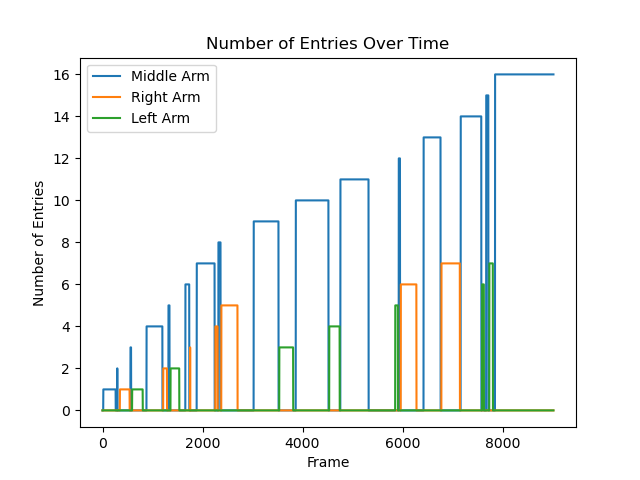

In [23]:
# Initialize the dictionaries
roi_entries_exits = {name: {f"{part1}-{part2}": {"entries": 0, "exits": 0, "in_roi": False, "debounce_counter": 0} for part1, part2 in body_part_pairs} for name in roi_names}
first_entry_roi = None
starting_roi = None

# Initialize a DataFrame to store the number of entries over time for each ROI
entries_over_time = pd.DataFrame(0, index=np.arange(len(df)), columns=roi_names)

# Update entries and exits for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            in_roi = is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi)
            if index == 0 and in_roi:
                starting_roi = name
            if in_roi and not roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["entries"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = True
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                    if first_entry_roi is None and name != starting_roi:
                        first_entry_roi = name
                    # Update entries_over_time every time the mouse enters an ROI
                    entries_over_time.loc[index, name] = roi_entries_exits[name][f"{part1}-{part2}"]["entries"]
            elif not in_roi and roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["exits"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = False
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
            else:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                entries_over_time.loc[index, name] = entries_over_time.loc[index - 1, name] if index > 0 else 0

# Plot the number of entries over time for each ROI
entries_over_time.plot()

plt.xlabel('Frame')
plt.ylabel('Number of Entries')
plt.title('Number of Entries Over Time')
plt.legend()
plt.show()


## Number of Entries Over Time (# of Frames) - Graphed Individually For Each ROI

<IPython.core.display.Javascript object>


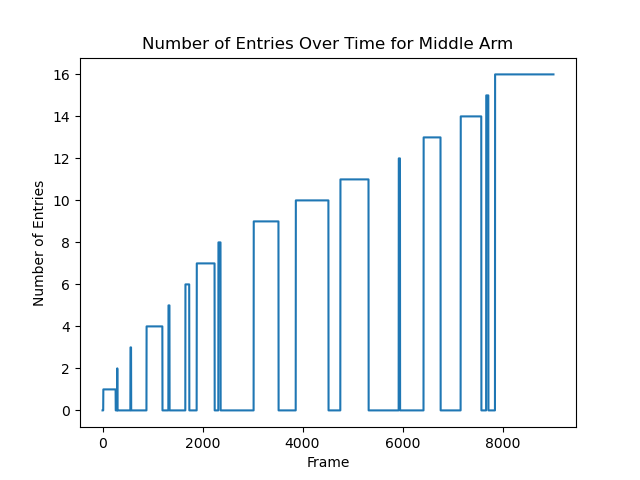

<IPython.core.display.Javascript object>


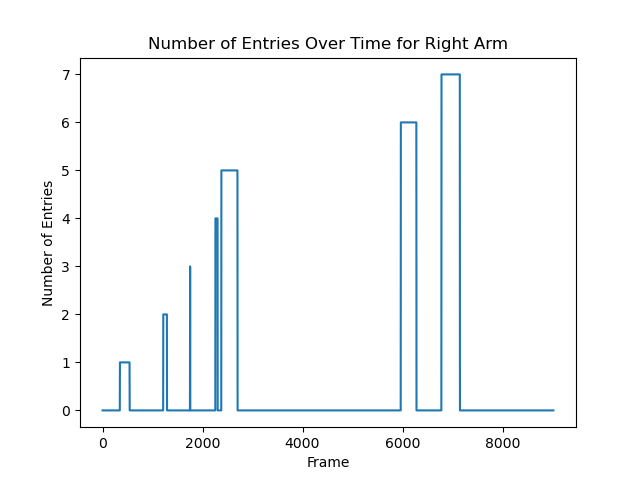

<IPython.core.display.Javascript object>


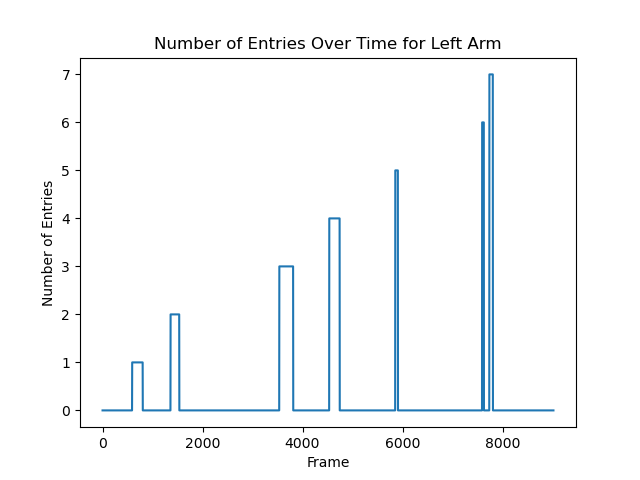

In [24]:
# Initialize the dictionaries
roi_entries_exits = {name: {f"{part1}-{part2}": {"entries": 0, "exits": 0, "in_roi": False, "debounce_counter": 0} for part1, part2 in body_part_pairs} for name in roi_names}
first_entry_roi = None
starting_roi = None

# Initialize a DataFrame to store the number of entries over time for each ROI
entries_over_time = pd.DataFrame(0, index=np.arange(len(df)), columns=roi_names)

# Update entries and exits for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            in_roi = is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi)
            if index == 0 and in_roi:
                starting_roi = name
            if in_roi and not roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["entries"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = True
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                    if first_entry_roi is None and name != starting_roi:
                        first_entry_roi = name
                    # Update entries_over_time every time the mouse enters an ROI
                    entries_over_time.loc[index, name] = roi_entries_exits[name][f"{part1}-{part2}"]["entries"]
            elif not in_roi and roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["exits"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = False
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
            else:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                entries_over_time.loc[index, name] = entries_over_time.loc[index - 1, name] if index > 0 else 0

# Plot the number of entries over time for each ROI
for name in roi_names:
    plt.figure()  # Create a new figure
    entries_over_time[name].plot()
    plt.xlabel('Frame')
    plt.ylabel('Number of Entries')
    plt.title(f'Number of Entries Over Time for {name}')
    plt.show()


## Frequency of Entries per ROI per Second

ROI 'Middle Arm': 0.053220977935469566 entries per second
ROI 'Right Arm': 0.023284177846767937 entries per second
ROI 'Left Arm': 0.023284177846767937 entries per second


<IPython.core.display.Javascript object>


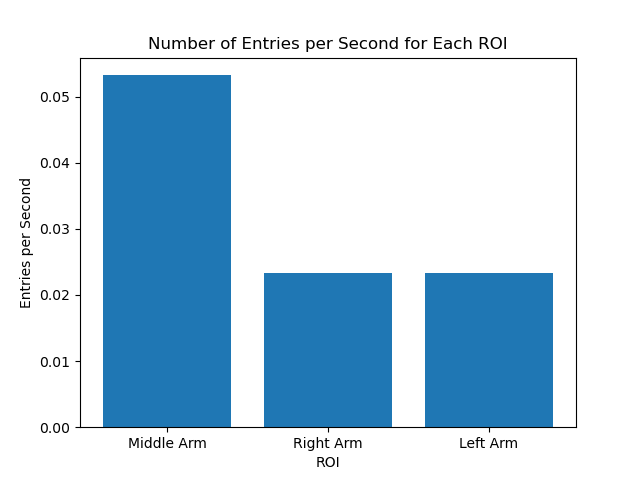

In [25]:
# Calculate the number of frames per second
fps = 30  # Change this to match your data

# Calculate the number of entries per second for each ROI
entries_per_second = {name: roi_entries_exits[name][f"{part1}-{part2}"]['entries'] / (len(df) / fps) for name in roi_names for part1, part2 in body_part_pairs}

# Print the number of entries per second for each ROI
for name in roi_names:
    print(f"ROI '{name}': {entries_per_second[name]} entries per second")

# Plot the number of entries per second for each ROI on a single bar graph
plt.figure()  # Create a new figure
plt.bar(entries_per_second.keys(), entries_per_second.values())
plt.xlabel('ROI')
plt.ylabel('Entries per Second')
plt.title('Number of Entries per Second for Each ROI')
plt.show()


## Temporal Analysis of ROI Visits

In [ ]:
# Temporal Analysis allows an insight into how the behavior changes over time.
# Trends: By observing the number of entries into each ROI over time, we can identify any trends or patterns. For example, if the mouse tends to enter a certain ROI more frequently in later time bins, this could indicate a change in behavior over time.
# Comparisons: Binning also allows us to compare the behavior in different time periods. For example, we can compare the number of entries into each ROI in the first half of the experiment to the second half.
# Variability: By looking at the variability in the number of entries across time bins, we can get a sense of how consistent the mouse’s behavior is. High variability might suggest that the mouse’s behavior changes a lot over time, while low variability could indicate more consistent behavior.

<IPython.core.display.Javascript object>


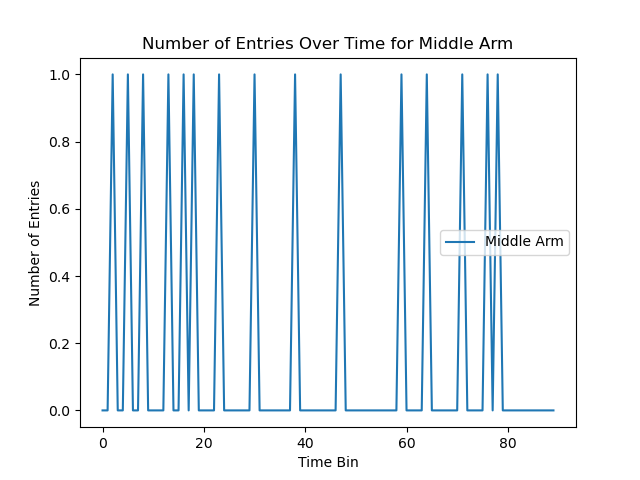

<IPython.core.display.Javascript object>


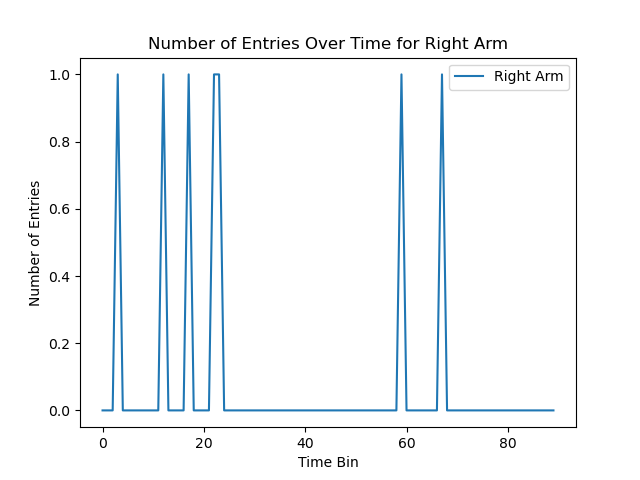

<IPython.core.display.Javascript object>


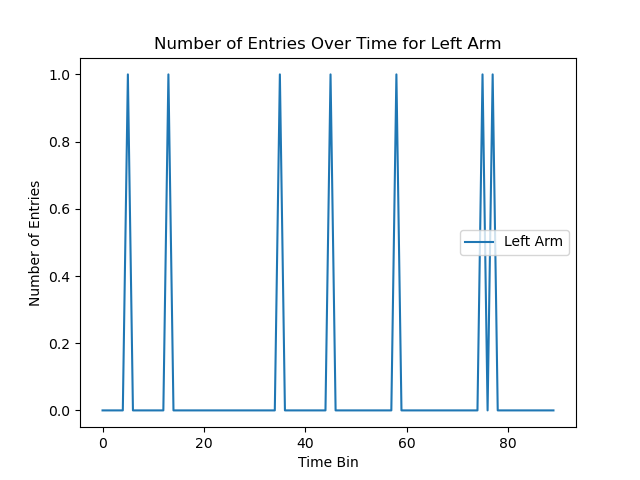

In [26]:
# Define the number of bins
num_bins = 90

# Calculate the number of frames per bin
frames_per_bin = len(df) // num_bins

# Initialize a dictionary to store the number of entries in each bin for each ROI
entries_in_bins = {name: np.zeros(num_bins) for name in roi_names}

# Update entries for each frame
for index in range(len(df)):
    for roi, name in zip(roi_coords, roi_names):
        for part1, part2 in body_part_pairs:
            in_roi = is_in_roi(body_part_data[part1]["x"][index], body_part_data[part1]["y"][index], roi)
            if in_roi and not roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["entries"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = True
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
                    # Update the number of entries in the current bin
                    bin_index = min(index // frames_per_bin, num_bins - 1)
                    entries_in_bins[name][bin_index] += 1
            elif not in_roi and roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"]:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] += 1
                if roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] >= debounce_frames:
                    roi_entries_exits[name][f"{part1}-{part2}"]["exits"] += 1
                    roi_entries_exits[name][f"{part1}-{part2}"]["in_roi"] = False
                    roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0
            else:
                roi_entries_exits[name][f"{part1}-{part2}"]["debounce_counter"] = 0

# Plot the number of entries in each bin for each ROI
for name in roi_names:
    plt.figure()  # Create a new figure
    plt.plot(entries_in_bins[name], label=name)
    plt.xlabel('Time Bin')
    plt.ylabel('Number of Entries')
    plt.title(f'Number of Entries Over Time for {name}')
    plt.legend()
    plt.show()
